In \[1\]:

    #from google.colab import drive
    #drive.mount('/content/drive')

In \[2\]:

    !pip install surprise

    Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
    Collecting surprise
      Downloading surprise-0.1-py2.py3-none-any.whl (1.8 kB)
    Collecting scikit-surprise
      Downloading scikit-surprise-1.1.1.tar.gz (11.8 MB)
         |████████████████████████████████| 11.8 MB 5.0 MB/s 
    Requirement already satisfied: joblib>=0.11 in /usr/local/lib/python3.7/dist-packages (from scikit-surprise->surprise) (1.1.0)
    Requirement already satisfied: numpy>=1.11.2 in /usr/local/lib/python3.7/dist-packages (from scikit-surprise->surprise) (1.21.6)
    Requirement already satisfied: scipy>=1.0.0 in /usr/local/lib/python3.7/dist-packages (from scikit-surprise->surprise) (1.7.3)
    Requirement already satisfied: six>=1.10.0 in /usr/local/lib/python3.7/dist-packages (from scikit-surprise->surprise) (1.15.0)
    Building wheels for collected packages: scikit-surprise
      Building wheel for scikit-surprise (setup.py) ... done
      Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633999 sha256=b0c5d36a560dc596e18980e4bad03dabbca9a578c008656ea7f2ae6093f4e947
      Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
    Successfully built scikit-surprise
    Installing collected packages: scikit-surprise, surprise
    Successfully installed scikit-surprise-1.1.1 surprise-0.1

In \[3\]:

    import warnings                                 
    warnings.filterwarnings('ignore')

    # Basic libraries of python for numeric and dataframe computations
    import numpy as np                              
    import pandas as pd

    # Basic library for data visualization
    import matplotlib.pyplot as plt     

    # Slightly advanced library for data visualization            
    import seaborn as sns                           

    # A dictionary output that does not raise a key error
    from collections import defaultdict             

    # A performance metrics in surprise
    from surprise import accuracy

    # Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
    from surprise.reader import Reader

    # Class for loading datasets
    from surprise.dataset import Dataset

    # For model tuning model hyper-parameters
    from surprise.model_selection import GridSearchCV

    # For splitting the rating data in train and test dataset
    from surprise.model_selection import train_test_split

    # For implementing similarity based recommendation system
    from surprise.prediction_algorithms.knns import KNNBasic

    # For implementing matrix factorization based recommendation system
    from surprise.prediction_algorithms.matrix_factorization import SVD

    # For implementing cross validation
    from surprise.model_selection import KFold

Loading the data

In \[13\]:

    from google.colab import files
    import io

    uploaded = files.upload()
    rating = pd.read_csv(io.BytesIO(uploaded['ratings.csv']))

Upload widget is only available when the cell has been executed in the
current browser session. Please rerun this cell to enable.

    Saving ratings.csv to ratings (2).csv

In \[14\]:

    rating.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 100004 entries, 0 to 100003
    Data columns (total 4 columns):
     #   Column     Non-Null Count   Dtype  
    ---  ------     --------------   -----  
     0   userId     100004 non-null  int64  
     1   movieId    100004 non-null  int64  
     2   rating     100004 non-null  float64
     3   timestamp  100004 non-null  int64  
    dtypes: float64(1), int64(3)
    memory usage: 3.1 MB

-   There are 1,00,004 observations and 4 columns in the data

<!-- -->

-   All the columns are of numeric data type
-   The data type of the timestamp column is int64 which is not correct.
    We can convert this to DateTime format but we don't need timestamp
    for our analysis. Hence, we can drop this column

Dropping timestamp column

In \[15\]:

    rating = rating.drop(['timestamp'], axis=1)

**Question 1: Exploring the dataset**

Let's explore the dataset and answer some basic data-related questions:

**Q 1.1 Print the top 5 rows of the dataset**

In \[17\]:

    rating.head()

Out\[17\]:

|     | userId | movieId | rating |
|-----|--------|---------|--------|
| 0   | 1      | 31      | 2.5    |
| 1   | 1      | 1029    | 3.0    |
| 2   | 1      | 1061    | 3.0    |
| 3   | 1      | 1129    | 2.0    |
| 4   | 1      | 1172    | 4.0    |



**Q 1.2 Describe the distribution of ratings.**

In \[18\]:

    plt.figure(figsize = (12, 4))

    sns.countplot(x="rating", data=rating)

    plt.tick_params(labelsize = 10)
    plt.title("Distribution of Ratings ", fontsize = 10)
    plt.xlabel("Ratings", fontsize = 10)
    plt.ylabel("Number of Ratings", fontsize = 10)
    plt.show()

<img
src="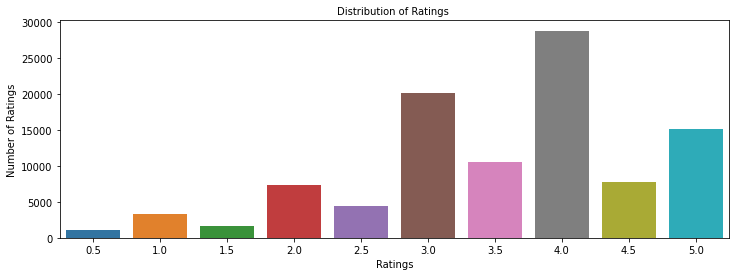%0A"
class="jp-needs-light-background" />

Ans 1.2

**Q 1.3 What is the total number of unique users and unique movies?**

In \[19\]:

    rating['userId'].nunique()

Out\[19\]:

    671

There are 671 unique users

In \[21\]:

    rating['movieId'].nunique()

Out\[21\]:

    9066

There are 9066 unique movies

**Q 1.4 Is there a movie in which the same user interacted with it more
than once?**

In \[22\]:

    rating.groupby(['userId', 'movieId']).count()

Out\[22\]:

|        |         | rating |
|--------|---------|--------|
| userId | movieId |        |
| 1      | 31      | 1      |
|        | 1029    | 1      |
|        | 1061    | 1      |
|        | 1129    | 1      |
|        | 1172    | 1      |
| ...    | ...     | ...    |
| 671    | 6268    | 1      |
|        | 6269    | 1      |
|        | 6365    | 1      |
|        | 6385    | 1      |
|        | 6565    | 1      |

100004 rows × 1 columns



In \[23\]:

    rating.groupby(['userId', 'movieId']).count()['rating'].sum()

Out\[23\]:

    100004

Ans 1.4 **The sum is equal to the total number of observations which
implies that there is only interaction between a pair of items and a
user.**

**Q 1.5 Which is the most interacted movie in the dataset?**

In \[24\]:

    rating['movieId'].value_counts()

Out\[24\]:

    356       341
    296       324
    318       311
    593       304
    260       291
             ... 
    98604       1
    103659      1
    104419      1
    115927      1
    6425        1
    Name: movieId, Length: 9066, dtype: int64

**Ans 1.5 The movie with MovieId:356 has been interacted by most users
which is 341 times.**

In \[25\]:

    plt.figure(figsize=(7,7))

    rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

    plt.xlabel('Rating')

    plt.ylabel('Count')

    plt.show()

<img
src="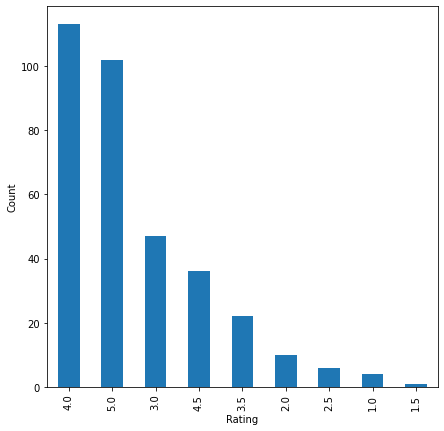%0A"
class="jp-needs-light-background" />

**We can see that this movie has been liked by the majority of users, as
the count of ratings 5 and 4 is higher than the count of other
ratings.**

**Q 1.6 Which user interacted the most with any movie in the dataset?**

In \[26\]:

    rating['userId'].value_counts()

Out\[26\]:

    547    2391
    564    1868
    624    1735
    15     1700
    73     1610
           ... 
    296      20
    289      20
    249      20
    221      20
    1        20
    Name: userId, Length: 671, dtype: int64

**The user with userId: 547 has interacted with the most number of items
i.e. 2391 times.**

**Q 1.7 What is the distribution of the user-movie interactions in this
dataset?**

In \[27\]:

    count_interactions = rating.groupby('userId').count()['movieId']
    count_interactions

Out\[27\]:

    userId
    1       20
    2       76
    3       51
    4      204
    5      100
          ... 
    667     68
    668     20
    669     37
    670     31
    671    115
    Name: movieId, Length: 671, dtype: int64

In \[28\]:

    plt.figure(figsize=(15,7))
    sns.histplot(count_interactions)

    plt.xlabel('Number of Interactions by Users')

    plt.show()

<img
src="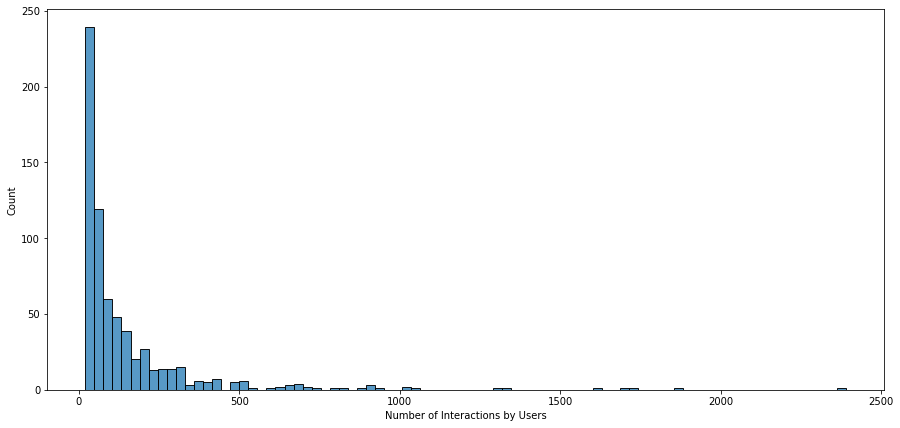%0A"
class="jp-needs-light-background" />

**The distribution is higher skewed to the right.There are some
outliers**

As we have now explored the data, let's start building Recommendation
systems

**Question 2: Create Rank-Based Recommendation System**

Model 1: Rank-Based Recommendation System Rank-based recommendation
systems provide recommendations based on the most popular items. This
kind of recommendation system is useful when we have cold start
problems. Cold start refers to the issue when we get a new user into the
system and the machine is not able to recommend movies to the new user,
as the user did not have any historical interactions in the dataset. In
those cases, we can use rank-based recommendation system to recommend
movies to the new user.

To build the rank-based recommendation system, we take average of all
the ratings provided to each movie and then rank them based on their
average rating.

In \[30\]:

    #calculate avg ratings
    average_rating = rating.groupby('movieId').mean()['rating']

    #Calculating the count of ratings
    count_rating = rating.groupby('movieId').count()['rating']

    # Making a dataframe with the count and average of ratings
    final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In \[31\]:

    final_rating.head()

Out\[31\]:

|         | avg_rating | rating_count |
|---------|------------|--------------|
| movieId |            |              |
| 1       | 3.872470   | 247          |
| 2       | 3.401869   | 107          |
| 3       | 3.161017   | 59           |
| 4       | 2.384615   | 13           |
| 5       | 3.267857   | 56           |



Now, let's create a function to find the top n movies for a
recommendation based on the average ratings of movies. We can also add a
threshold for a minimum number of interactions for a movie to be
considered for recommendation.

In \[32\]:

    def top_n_movies(data, n, min_interaction=100):
        
        #Finding movies with minimum number of interactions
        recommendations = data[data['rating_count'] >= min_interaction]
        
        #Sorting values w.r.t average rating 
        recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
        
        return recommendations.index[:n]

We can use this function with different n's and minimum interactions to
get movies to recommend

Recommending top 5 movies with 50 minimum interactions based on
popularity

In \[33\]:

    list(top_n_movies(final_rating, 5, 50))

Out\[33\]:

    [858, 318, 969, 913, 1221]

We have recommended the top 5 movies by using the popularity
recommendation system. Now, let's build a recommendation system using
collaborative filtering.

**Recommending top 5 movies with 100 minimum interactions based on
popularity**

In \[34\]:

    list(top_n_movies(final_rating, 5, 100))

Out\[34\]:

    [858, 318, 1221, 50, 527]

**Recommending top 5 movies with 200 minimum interactions based on
popularity**

In \[35\]:

    list(top_n_movies(final_rating, 5, 200))

Out\[35\]:

    [858, 318, 50, 527, 608]

Now that we have seen how to apply the Rank-Based Recommendation System,
let's apply the Collaborative Filtering Based Recommendation Systems.

**Model 2: User based Collaborative Filtering Recommendation System**

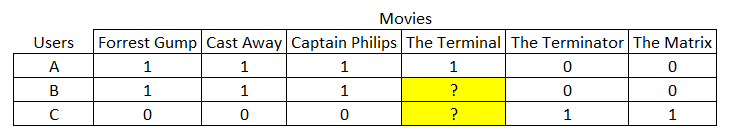

In the above interactions matrix, out of users B and C, which user is
most likely to interact with the movie, "The Terminal"?

In this type of recommendation system, we do not need any information
about the users or items. We only need user item interaction data to
build a collaborative recommendation system. For example -

Ratings provided by users. For example - ratings of books on goodread,
movie ratings on imdb etc Likes of users on different facebook posts,
likes on youtube videos Use/buying of a product by users. For example -
buying different items on e-commerce sites Reading of articles by
readers on various blogs Types of Collaborative Filtering

Similarity/Neighborhood based

User-User Similarity Based Item-Item similarity based Model based

Building Similarity/Neighborhood based Collaborative Filtering

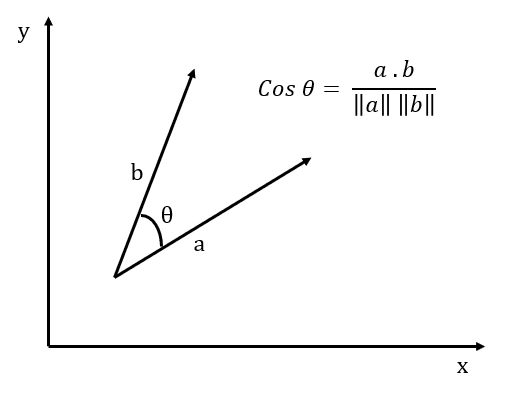

Building a baseline user-user similarity based recommendation system
Below, we are building similarity-based recommendation systems using
cosine similarity and using KNN to find similar users which are the
nearest neighbor to the given user. We will be using a new library,
called surprise, to build the remaining models. Let's first import the
necessary classes and functions from this library. Below we are loading
the rating dataset, which is a pandas DataFrame, into a different format
called surprise.dataset.DatasetAutoFolds, which is required by this
library. To do this, we will be using the classes Reader and Dataset.
Finally splitting the data into train and test set.

Making the dataset into surprise dataset and splitting it into train and
test set

In \[36\]:

    # Instantiating Reader scale with expected rating scale
    reader = Reader(rating_scale=(0, 5))

    # Loading the rating dataset
    data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

    # Splitting the data into train and test dataset
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Build the first baseline similarity based recommendation system using
cosine similarity and KNN

In \[38\]:

    sim_options = {'name': 'cosine',
                   'user_based': True}

    # Defining Nearest neighbour algorithm
    algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

    # Train the algorithm on the trainset or fitting the model on train dataset 
    algo_knn_user.fit(trainset)

    # Predict ratings for the testset
    predictions = algo_knn_user.test(testset)

    # Then compute RMSE
    accuracy.rmse(predictions)

    RMSE: 0.9925

Out\[38\]:

    0.9924509041520163

**Q 3.1 What is the RMSE for baseline user based collaborative filtering
recommendation system?**

Ans 3.1 RMSE: 0.9925

**Q 3.2 What is the Predicted rating for an user with userId=4 and for
movieId=10 and movieId=3?**

Let's us now predict rating for an user with userId=4 and for movieId=10

In \[39\]:

    algo_knn_user.predict(4,10, r_ui=4, verbose=True)

    user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}

Out\[39\]:

    Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

Ans 3.2 As we can see - the actual rating for this user-item pair is 4
and predicted rating is 3.62 by this similarity based baseline model

Let's predict the rating for the same userId=4 but for a movie which
this user has not interacted before i.e. movieId=3

In \[40\]:

    algo_knn_user.predict(4,3, verbose=True)

    user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}

Out\[40\]:

    Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

As we can see the estimated rating for this user-item pair is 3.20 based
on this similarity based baseline model

**Improving user-user similarity based recommendation system by tuning
its hyper-parameters**

Below we will be tuning hyper-parmeters for the KNNBasic algorithms.
Let's try to understand different hyperparameters of KNNBasic algorithm
-

k (int) – The (max) number of neighbors to take into account for
aggregation (see this note). Default is 40.

min_k (int) – The minimum number of neighbors to take into account for
aggregation. If there are not enough neighbors, the prediction is set to
the global mean of all ratings. Default is 1.

sim_options (dict) – A dictionary of options for the similarity measure.
And there are four similarity measures available in surprise -

cosine msd (default) pearson pearson baseline

**Q 3.3 Perform hyperparameter tuning for the baseline user based
collaborative filtering recommendation system and find the RMSE for
tuned user based collaborative filtering recommendation system?**

In \[50\]:

    # Setting up parameter grid to tune the hyperparameters
    param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
                  'sim_options': {'name': ['msd', 'cosine'],
                                  'user_based': [True]}
                  }

    # Performing 3-fold cross validation to tune the hyperparameters
    grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

    # Fitting the data
    grid_obj.fit(data)

    # Best RMSE score
    print(grid_obj.best_score['rmse'])

    # Combination of parameters that gave the best RMSE score
    print(grid_obj.best_params['rmse'])

    0.9643925030114247
    {'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}

Once the grid search is complete, we can get the optimal values for each
of those hyperparameters as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and
every split to analyze the impact of each value of hyperparameters

In \[51\]:

    results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
    results_df.head()

Out\[51\]:

|     | split0_test_rmse | split1_test_rmse | split2_test_rmse | mean_test_rmse | std_test_rmse | rank_test_rmse | split0_test_mae | split1_test_mae | split2_test_mae | mean_test_mae | std_test_mae | rank_test_mae | mean_fit_time | std_fit_time | mean_test_time | std_test_time | params                                            | param_k | param_min_k | param_sim_options                      |
|-----|------------------|------------------|------------------|----------------|---------------|----------------|-----------------|-----------------|-----------------|---------------|--------------|---------------|---------------|--------------|----------------|---------------|---------------------------------------------------|---------|-------------|----------------------------------------|
| 0   | 0.961998         | 0.967938         | 0.963242         | 0.964393       | 0.002558      | 1              | 0.740118        | 0.743909        | 0.740920        | 0.741649      | 0.001631     | 1             | 0.142638      | 0.019521     | 3.226619       | 0.123009      | {'k': 20, 'min_k': 3, 'sim_options': {'name': ... | 20      | 3           | {'name': 'msd', 'user_based': True}    |
| 1   | 0.990889         | 0.997509         | 0.991677         | 0.993359       | 0.002953      | 14             | 0.766354        | 0.770336        | 0.766853        | 0.767847      | 0.001771     | 12            | 0.690484      | 0.109555     | 3.216189       | 0.121579      | {'k': 20, 'min_k': 3, 'sim_options': {'name': ... | 20      | 3           | {'name': 'cosine', 'user_based': True} |
| 2   | 0.965907         | 0.970787         | 0.966149         | 0.967614       | 0.002246      | 3              | 0.742444        | 0.747582        | 0.743217        | 0.744414      | 0.002262     | 3             | 0.154446      | 0.030559     | 3.045786       | 0.059491      | {'k': 20, 'min_k': 6, 'sim_options': {'name': ... | 20      | 6           | {'name': 'msd', 'user_based': True}    |
| 3   | 0.992899         | 0.998791         | 0.992905         | 0.994865       | 0.002776      | 15             | 0.767195        | 0.772618        | 0.767792        | 0.769201      | 0.002428     | 15            | 0.705828      | 0.034392     | 3.063679       | 0.064864      | {'k': 20, 'min_k': 6, 'sim_options': {'name': ... | 20      | 6           | {'name': 'cosine', 'user_based': True} |
| 4   | 0.972405         | 0.976475         | 0.970717         | 0.973199       | 0.002417      | 7              | 0.747756        | 0.752383        | 0.746866        | 0.749002      | 0.002418     | 6             | 0.221735      | 0.092205     | 3.634563       | 0.422156      | {'k': 20, 'min_k': 9, 'sim_options': {'name': ... | 20      | 9           | {'name': 'msd', 'user_based': True}    |



Now, let's build the final model by using tuned values of the
hyperparameters, which we received by using grid search
cross-validation.

In \[52\]:

    # Using the optimal similarity measure for user-user based collaborative filtering
    sim_options = {'name': 'cosine',
                   'user_based': True}
    # Creating an instance of KNNBasic with optimal hyperparameter values
    similarity_algo_optimized_user = KNNBasic(sim_options=sim_options,verbose=False)

    # Training the algorithm on the trainset
    similarity_algo_optimized_user.fit(trainset)

    # Predicting ratings for the testset
    predictions = similarity_algo_optimized_user.test(testset)

    # Computing RMSE on testset
    accuracy.rmse(predictions)

    RMSE: 0.9925

Out\[52\]:

    0.9924509041520163

We can see from above that after tuning hyperparameters, RMSE for
testset has not chnaged much it remains 0.9925

**Q 3.4 What is the Predicted rating for an user with userId =4 and for
movieId= 10 and movieId=3 using tuned user based collaborative
filtering?**

Let's us now predict rating for an user with userId=4 and for movieId=10
with the optimized model

In \[53\]:

    similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

    user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}

Out\[53\]:

    Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

If we compare the above predicted rating, we can see the baseline model
predicted rating as 4 and the optimized model predicted the rating as 4

Below we are predicting rating for the same userId=4 but for a movie
which this user has not interacted before i.e. movieId=3, by using the
optimized model as shown below -

In \[54\]:

    similarity_algo_optimized_user.predict(0,100, verbose=True)

    user: 0          item: 100        r_ui = None   est = 3.55   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}

Out\[54\]:

    Prediction(uid=0, iid=100, r_ui=None, est=3.5459045285801785, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

If we compare the above predicted rating, we can see the baseline model
predicted rating as 3.20 and the optimized model predicted the rating as
3.55

**Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest
neighbors based on this KNNBasic algorithm. Below we are finding 5 most
similar user to the userId=4 based on the msd distance metric

In \[55\]:

    similarity_algo_optimized_user.get_neighbors(4, k=5)

Out\[55\]:

    [357, 220, 590, 491, 647]

**Implementing the recommendation algorithm based on optimized KNNBasic
model**¶

Below we will be implementing a function where the input parameters are
-

data: a rating dataset user_id: an user id against which we want the
recommendations

top_n: the number of movies we want to recommend

algo: the algorithm we want to use to predict the ratings

In \[56\]:

    def get_recommendations(data, user_id, top_n, algo):
        
        # Creating an empty list to store the recommended movie ids
        recommendations = []
        
        # Creating an user item interactions matrix 
        user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
        
        # Extracting those movie ids which the user_id has not interacted yet
        non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
        
        # Looping through each of the movie id which user_id has not interacted yet
        for item_id in non_interacted_movies:
            
            # Predicting the ratings for those non interacted movie ids by this user
            est = algo.predict(user_id, item_id).est
            
            # Appending the predicted ratings
            recommendations.append((item_id, est))

        # Sorting the predicted ratings in descending order
        recommendations.sort(key=lambda x: x[1], reverse=True)

        return recommendations[:top_n] # returing top n highest predicted rating movies for this user

Predicted top 5 movies for userId=4 with similarity based recommendation
system

In \[57\]:

    recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

**Q 3.5 Predict the top 5 movies for userId=4 with similarity based
recommendation system**

In \[58\]:

    recommendations

Out\[58\]:

    [(53, 5), (183, 5), (301, 5), (309, 5), (363, 5)]

**Model 3: Item based Collaborative Filtering Recommendation System**

In \[59\]:

    # Definfing similarity measure
    sim_options = {'name': 'cosine',
                   'user_based': False}

    # Defining Nearest neighbour algorithm
    algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

    # Train the algorithm on the trainset or fitting the model on train dataset 
    algo_knn_item.fit(trainset)

    # Predict ratings for the testset
    predictions = algo_knn_item.test(testset)

    # Then compute RMSE
    accuracy.rmse(predictions)

    RMSE: 1.0032

Out\[59\]:

    1.003221450633729

**Q 4.1 What is the RMSE for baseline item based collaborative filtering
recommendation system ?**

Ans 4.1 RMSE: 1.0032

Let's us now predict rating for an user with userId=4 and for movieId=10

**Q 4.2 What is the Predicted rating for an user with userId =4 and for
movieId= 10 and movieId=3?**

In \[60\]:

    algo_knn_item.predict(4,10, r_ui=4, verbose=True)

    user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}

Out\[60\]:

    Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

As we can see - the actual rating for this user-item pair is 4 and
predicted rating is 4.37 by this similarity based baseline model

Let's predict the rating for the same userId=4 but for a movie which
this user has not interacted before i.e. movieId=3

In \[61\]:

    # Remove _______ and complete the code
    algo_knn_item.predict(4,3, verbose=True)

    user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}

Out\[61\]:

    Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

As we can see the estimated rating for this user-item pair is 4.07 based
on this similarity based baseline model

**Q 4.3 Perform hyperparameter tuning for the baseline item based
collaborative filtering recommendation system and find the RMSE for
tuned item based collaborative filtering recommendation system?**

In \[63\]:

    # Setting up parameter grid to tune the hyperparameters
    param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
                  'sim_options': {'name': ['msd', 'cosine'],
                                  'user_based': [False]}
                  }

    # Performing 3-fold cross validation to tune the hyperparameters
    grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

    # Fitting the data
    grid_obj.fit(data)

    # Best RMSE score
    print(grid_obj.best_score['rmse'])

    # Combination of parameters that gave the best RMSE score
    print(grid_obj.best_params['rmse'])

    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the msd similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    Computing the cosine similarity matrix...
    Done computing similarity matrix.
    0.9406196137570685
    {'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}

Once the grid search is complete, we can get the optimal values for each
of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and
every split to analyze the impact of each value of hyperparameters

In \[64\]:

    results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
    results_df.head()

Out\[64\]:

|     | split0_test_rmse | split1_test_rmse | split2_test_rmse | mean_test_rmse | std_test_rmse | rank_test_rmse | split0_test_mae | split1_test_mae | split2_test_mae | mean_test_mae | std_test_mae | rank_test_mae | mean_fit_time | std_fit_time | mean_test_time | std_test_time | params                                            | param_k | param_min_k | param_sim_options                       |
|-----|------------------|------------------|------------------|----------------|---------------|----------------|-----------------|-----------------|-----------------|---------------|--------------|---------------|---------------|--------------|----------------|---------------|---------------------------------------------------|---------|-------------|-----------------------------------------|
| 0   | 0.955477         | 0.946890         | 0.950444         | 0.950937       | 0.003523      | 7              | 0.738635        | 0.731601        | 0.732329        | 0.734188      | 0.003158     | 7             | 3.161336      | 0.072937     | 9.659638       | 0.516563      | {'k': 20, 'min_k': 3, 'sim_options': {'name': ... | 20      | 3           | {'name': 'msd', 'user_based': False}    |
| 1   | 1.017415         | 1.008323         | 1.016917         | 1.014218       | 0.004173      | 16             | 0.794838        | 0.788348        | 0.792021        | 0.791736      | 0.002657     | 16            | 10.188271     | 0.208551     | 8.946964       | 0.179255      | {'k': 20, 'min_k': 3, 'sim_options': {'name': ... | 20      | 3           | {'name': 'cosine', 'user_based': False} |
| 2   | 0.956195         | 0.946949         | 0.950579         | 0.951241       | 0.003804      | 8              | 0.739126        | 0.732012        | 0.732528        | 0.734555      | 0.003239     | 8             | 3.071243      | 0.079161     | 9.120448       | 0.140174      | {'k': 20, 'min_k': 6, 'sim_options': {'name': ... | 20      | 6           | {'name': 'msd', 'user_based': False}    |
| 3   | 1.018266         | 1.008465         | 1.017112         | 1.014614       | 0.004374      | 17             | 0.795437        | 0.788749        | 0.792304        | 0.792163      | 0.002732     | 17            | 10.429249     | 0.342197     | 9.179376       | 0.097754      | {'k': 20, 'min_k': 6, 'sim_options': {'name': ... | 20      | 6           | {'name': 'cosine', 'user_based': False} |
| 4   | 0.956612         | 0.947844         | 0.950755         | 0.951737       | 0.003646      | 9              | 0.739378        | 0.732657        | 0.732582        | 0.734872      | 0.003186     | 9             | 3.067096      | 0.057038     | 9.249053       | 0.119999      | {'k': 20, 'min_k': 9, 'sim_options': {'name': ... | 20      | 9           | {'name': 'msd', 'user_based': False}    |



Now let's build the final model by using tuned values of the
hyperparameters which we received by using grid search cross-validation.

In \[65\]:

    # Creating an instance of KNNBasic with optimal hyperparameter values
    # Creating an instance of KNNBasic with optimal hyperparameter values
    similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

    # Training the algorithm on the trainset
    similarity_algo_optimized_item.fit(trainset)

    # Predicting ratings for the testset
    predictions = similarity_algo_optimized_item.test(testset)

    # Computing RMSE on testset
    accuracy.rmse(predictions)

    RMSE: 0.9465

Out\[65\]:

    0.9465120620317036

We can see from above that after tuning hyperparameters, RMSE for
testset has reduced to 0.94

**Q 4.4 What is the Predicted rating for an item with userId =4 and for
movieId= 10 and movieId=3 using tuned item based collaborative
filtering?**

Let's us now predict rating for an user with userId=4 and for movieId=10
with the optimized model as shown below

In \[66\]:

    similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

    user: 4          item: 10         r_ui = 4.00   est = 4.30   {'actual_k': 30, 'was_impossible': False}

Out\[66\]:

    Prediction(uid=4, iid=10, r_ui=4, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

If we compare the above predicted rating, we can see the baseline model
predicted rating as 4 and the optimized model predicted the rating as
4.30. whereas the actual rating is 4.0.

Let's predict the rating for the same userId=4 but for a movie which
this user has not interacted before i.e. movieId=3, by using the
optimized model:

In \[67\]:

    similarity_algo_optimized_item.predict(4,3, verbose=True)

    user: 4          item: 3          r_ui = None   est = 3.86   {'actual_k': 30, 'was_impossible': False}

Out\[67\]:

    Prediction(uid=4, iid=3, r_ui=None, est=3.859023126306401, details={'actual_k': 30, 'was_impossible': False})

If we compare the above predicted rating, we can see the optimized model
predicted the rating as 4.29.

Identifying similar users to a given user (nearest neighbors) We can
also find out the similar users to a given user or its nearest neighbors
based on this KNNBasic algorithm. Below we are finding 5 most similar
user to the userId=4 based on the msd distance metric

In \[68\]:

    similarity_algo_optimized_item.get_neighbors(4, k=5)

Out\[68\]:

    [77, 85, 115, 119, 127]

**Q 4.5 Predict the top 5 movies for userId=4 with similarity based
recommendation system**

In \[69\]:

    recommendations

Out\[69\]:

    [(53, 5), (183, 5), (301, 5), (309, 5), (363, 5)]

**Model 4: Based Collaborative Filtering - Matrix Factorization using
SVD**

Model-based Collaborative Filtering is a personalized recommendation
system, the recommendations are based on the past behavior of the user
and it is not dependent on any additional information. We use latent
features to find recommendations for each user.

Latent Features: The features that are not present in the empirical data
but can be inferred from the data. For example:

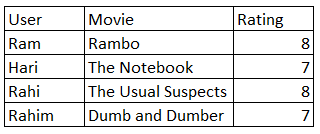

Now if we notice the above movies closely:

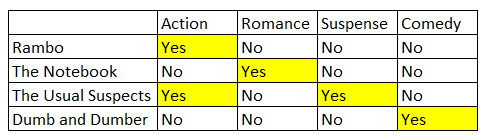

Here Action, Romance, Suspense and Comedy are latent features of the
corresponding movies. Similarly, we can compute the latent features for
users as shown below:

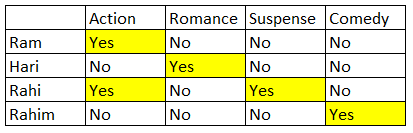

**Singular Value Decomposition (SVD)**

SVD is used to compute the latent features from the user-item matrix.
But SVD does not work when we miss values in the user-item matrix.

First we need to convert the below movie-rating dataset:

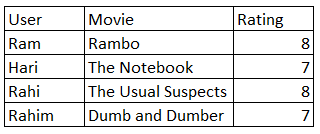

into an user-item matrix as shown below:

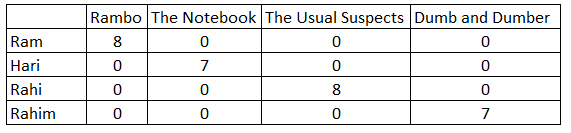

We have already done this above while computing cosine similarities.

SVD decomposes this above matrix into three separate matrices:

U matrix

Sigma matrix

V transpose matrix

U-matrix

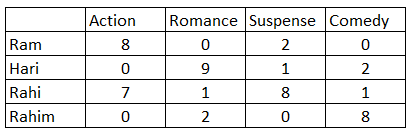

the above matrix is a n x k matrix, where:

n is number of users

k is number of latent features

Sigma-matrix

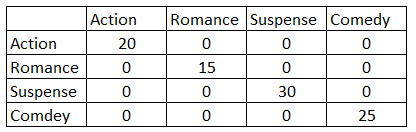

the above matrix is a k x k matrix, where:

k is number of latent features

Each diagonal entry is the singular value of the original interaction
matrix

V-transpose matrix

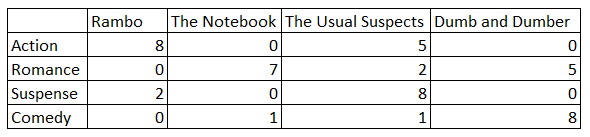

the above matrix is a kxn matrix, where:

k is the number of latent features

n is the number of items

**Build a baseline matrix factorization recommendation system**

In \[70\]:

    # Using SVD matrix factorization
    algo_svd = SVD()

    # Training the algorithm on the trainset
    algo_svd.fit(trainset)

    # Predicting ratings for the testset
    predictions = algo_svd.test(testset)

    # Computing RMSE on the testset
    accuracy.rmse(predictions)

    RMSE: 0.9013

Out\[70\]:

    0.9012672250541778

**Q 5.1 What is the RMSE for baseline SVD based collaborative filtering
recommendation system?**

RMSE: 0.9013

**Q 5.2 What is the Predicted rating for an user with userId =4 and for
movieId= 10 and movieId=3?**

Let's us now predict rating for an user with userId=4 and for movieId=10

In \[71\]:

    algo_svd.predict(4,10, r_ui=4, verbose=True)

    user: 4          item: 10         r_ui = 4.00   est = 3.72   {'was_impossible': False}

Out\[71\]:

    Prediction(uid=4, iid=10, r_ui=4, est=3.723337839452471, details={'was_impossible': False})

As we can see - the actual rating for this user-item pair is 4 and
predicted rating is 3.72 by this matrix factorization based baseline
model.

Let's predict the rating for the same userId=4 but for a movie which
this user has not interacted before i.e. movieId=3:

In \[72\]:

    algo_svd.predict(4, 3, verbose=True)

    user: 4          item: 3          r_ui = None   est = 3.49   {'was_impossible': False}

Out\[72\]:

    Prediction(uid=4, iid=3, r_ui=None, est=3.4923684289991965, details={'was_impossible': False})

We can see that estimated rating for this user-item pair is 3.49 based
on this matrix factorization based baseline model.

**Improving matrix factorization based recommendation system by tuning
its hyper-parameters**

In SVD, rating is predicted as -

r^ui=μ+bu+bi+qTipu

If user u is unknown, then the bias bu and the factors pu are assumed to
be zero. The same applies for item i with bi and qi.

To estimate all the unknown, we minimize the following regularized
squared error:

∑rui∈Rtrain (rui−r^ui)2+λ(b2i+b2u+∥qi∥2+∥pu∥2)

The minimization is performed by a very straightforward stochastic
gradient descent:

bubipuqi←bu+γ(eui−λbu)←bi+γ(eui−λbi)←pu+γ(eui⋅qi−λpu)←qi+γ(eui⋅pu−λqi)

There are many hyperparameters to tune in this algorithm, you can find a
full list of hyperparameters here

Below we will be tuning only three hyperparameters -

n_epochs: The number of iteration of the SGD algorithm

lr_all: The learning rate for all parameters

reg_all: The regularization term for all parameters

**Q 5.3 Perform hyperparameter tuning for the baseline SVD based
collaborative filtering recommendation system and find the RMSE for
tuned SVD based collaborative filtering recommendation system?**

In \[74\]:

    # Set the parameter space to tune
    param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
                  'reg_all': [0.2, 0.4, 0.6]}

    # Performing 3-fold gridsearch cross validation
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

    # Fitting data
    gs.fit(data)

    # Best RMSE score
    print(gs.best_score['rmse'])

    # Combination of parameters that gave the best RMSE score
    print(gs.best_params['rmse'])

    0.8940668397473432
    {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}

Once the grid search is complete, we can get the optimal values for each
of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and
every split to analyze the impact of each value of hyperparameters

In \[75\]:

    results_df = pd.DataFrame.from_dict(gs.cv_results)
    results_df.head()

Out\[75\]:

|     | split0_test_rmse | split1_test_rmse | split2_test_rmse | mean_test_rmse | std_test_rmse | rank_test_rmse | split0_test_mae | split1_test_mae | split2_test_mae | mean_test_mae | std_test_mae | rank_test_mae | mean_fit_time | std_fit_time | mean_test_time | std_test_time | params                                            | param_n\_epochs | param_lr_all | param_reg_all |
|-----|------------------|------------------|------------------|----------------|---------------|----------------|-----------------|-----------------|-----------------|---------------|--------------|---------------|---------------|--------------|----------------|---------------|---------------------------------------------------|-----------------|--------------|---------------|
| 0   | 0.940651         | 0.945354         | 0.943428         | 0.943144       | 0.001931      | 25             | 0.736495        | 0.740036        | 0.738029        | 0.738187      | 0.001450     | 25            | 4.910071      | 0.560483     | 0.596386       | 0.041060      | {'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2} | 10              | 0.001        | 0.2           |
| 1   | 0.945330         | 0.949254         | 0.948331         | 0.947638       | 0.001675      | 26             | 0.741302        | 0.744549        | 0.744187        | 0.743346      | 0.001453     | 26            | 5.205417      | 0.173866     | 0.652716       | 0.118310      | {'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4} | 10              | 0.001        | 0.4           |
| 2   | 0.950732         | 0.954202         | 0.953770         | 0.952901       | 0.001544      | 27             | 0.747419        | 0.749860        | 0.749875        | 0.749051      | 0.001155     | 27            | 5.276946      | 0.075921     | 0.609151       | 0.106657      | {'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6} | 10              | 0.001        | 0.6           |
| 3   | 0.904513         | 0.909898         | 0.906098         | 0.906836       | 0.002260      | 11             | 0.700172        | 0.704610        | 0.701841        | 0.702208      | 0.001830     | 9             | 5.249236      | 0.104642     | 0.605014       | 0.018628      | {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2} | 10              | 0.005        | 0.2           |
| 4   | 0.911462         | 0.916256         | 0.913488         | 0.913736       | 0.001965      | 15             | 0.707845        | 0.711550        | 0.709867        | 0.709754      | 0.001515     | 15            | 5.500850      | 0.233116     | 0.677602       | 0.031726      | {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4} | 10              | 0.005        | 0.4           |



Now, we will the build final model by using tuned values of the
hyperparameters, which we received using grid search cross-validation
above.

In \[77\]:

    # Building the optimized SVD model using optimal hyperparameter search
    svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2)

    # Training the algorithm on the trainset
    svd_algo_optimized.fit(trainset)

    # Predicting ratings for the testset
    predictions = svd_algo_optimized.test(testset)

    # Computing RMSE
    accuracy.rmse(predictions)

    RMSE: 0.8968

Out\[77\]:

    0.8968085059474744

**Q 5.4 What is the Predicted rating for an user with userId =4 and for
movieId= 10 and movieId=3 using SVD based collaborative filtering?**

Let's us now predict rating for an user with userId=4 and for movieId=10
with the optimized model

In \[78\]:

    svd_algo_optimized.predict(4,10, r_ui=4, verbose=True)

    user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}

Out\[78\]:

    Prediction(uid=4, iid=10, r_ui=4, est=3.9855456137476613, details={'was_impossible': False})

Predicted rating for an user is actual 4 and estimated 3.99

Let's predict the rating for the same userId=4 but for a movie which
this user has not interacted before i.e. movieId=3:

In \[79\]:

    svd_algo_optimized.predict(4,3, verbose=True)

    user: 4          item: 3          r_ui = None   est = 3.64   {'was_impossible': False}

Out\[79\]:

    Prediction(uid=4, iid=3, r_ui=None, est=3.638472529121346, details={'was_impossible': False})

**Q 5.5 Predict the top 5 movies for userId=4 with SVD based
recommendation system?**

In \[80\]:

    get_recommendations(rating,4,5, svd_algo_optimized)

Out\[80\]:

    [(926, 4.944205427318147),
     (1192, 4.878310197886854),
     (3035, 4.873456795783375),
     (1217, 4.865617458565947),
     (1948, 4.853795224124474)]

Predicting ratings for already interacted movies

Below we are comparing the rating predictions of users for those movies
which has been already watched by an user. This will help us to
understand how well are predictions are as compared to the actual
ratings provided by users

In \[81\]:

    def predict_already_interacted_ratings(data, user_id, algo):
        
        # Creating an empty list to store the recommended movie ids
        recommendations = []
        
        # Creating an user item interactions matrix 
        user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
        
        # Extracting those movie ids which the user_id has interacted already
        interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
        
        # Looping through each of the movie id which user_id has interacted already
        for item_id in interacted_movies:

           # Extracting actual ratings
            actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
            
            # Predicting the ratings for those non interacted movie ids by this user
            predicted_rating = algo.predict(user_id, item_id).est
            
            # Appending the predicted ratings
            recommendations.append((item_id, actual_rating, predicted_rating))

        # Sorting the predicted ratings in descending order
        recommendations.sort(key=lambda x: x[1], reverse=True)

        return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by similarity based
recommendation system against actual ratings for userId=7

In \[82\]:

    predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
    df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
    sns.displot(data=df, x='value', hue='variable', kde=True);

<img
src="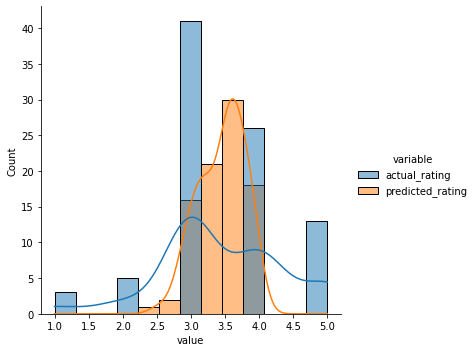%0A"
class="jp-needs-light-background" />

We can see that distribution of predicted ratings is closely following
the distribution of actual ratings. The total bins for predicted ratings
are nearly same as to the total bins for actual ratings

We are getting more predicted values in between 3 and 4,this is
expected, as actual ratings always have discreet values like 1, 2, 3, 4,
5, but predicted ratings can have continuous values as we are taking
aggregated ratings from the nearest neighbors of a given user. But over
the predictions looks good as compared to the distribution of actual
ratings.

Below we are comparing the predicted ratings by matrix factorization
based recommendation system against actual ratings for userId=7

In \[83\]:

    predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
    df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
    sns.displot(data=df, x='value', hue='variable', kde=True);

<img
src="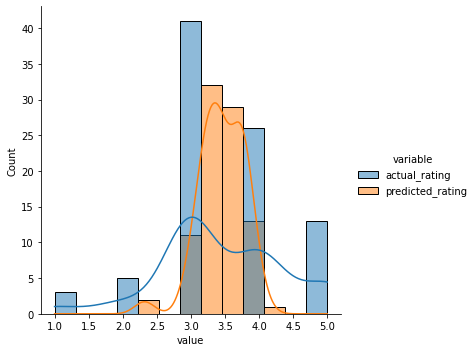%0A"
class="jp-needs-light-background" />

In \[84\]:

    # Instantiating Reader scale with expected rating scale
    reader = Reader(rating_scale=(0, 5))

    # Loading the rating dataset
    data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

    # Splitting the data into train and test dataset
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Precision and Recall @ k RMSE is not the only metric we can use here. We
can also examine two fundamental measures, precision and recall. We also
add a parameter k which is helpful in understanding problems with
multiple rating outputs.

Precision@k - It is the fraction of recommended items that are relevant
in top k predictions. Value of k is the number of recommendations to be
provided to the user. One can choose a variable number of
recommendations to be given to a unique user.

Recall@k - It is the fraction of relevant items that are recommended to
the user in top k predictions.

Recall - It is the fraction of actually relevant items that are
recommended to the user i.e. if out of 10 relevant movies, 6 are
recommended to the user then recall is 0.60. Higher the value of recall
better is the model. It is one of the metrics to do the performance
assessment of classification models.

Precision - It is the fraction of recommended items that are relevant
actually i.e. if out of 10 recommended items, 6 are found relevant by
the user then precision is 0.60. The higher the value of precision
better is the model. It is one of the metrics to do the performance
assessment of classification models.

See the Precision and Recall @ k section of your notebook and follow the
instructions to compute various precision/recall values at various
values of k.

**Question6: Compute the precision and recall, for each of the 6 models,
at k = 5 and 10. This is 6 x 2 = 12 numerical values?**

In \[85\]:

    # Function can be found on surprise documentation FAQs
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""

        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
     # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                  for (est, true_r) in user_ratings[:k])

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        return precisions, recalls

In \[86\]:

    # A basic cross-validation iterator.
    kf = KFold(n_splits=5)

    # Make list of k values
    K = [5, 10]

    # Remove _______ and complete the code
    # Make list of models
    models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

    for k in K:
        for model in models:
            print('> k={}, model={}'.format(k,model.__class__.__name__))
            p = []
            r = []
            for trainset, testset in kf.split(data):
                model.fit(trainset)
                predictions = model.test(testset, verbose=False)
                precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

                # Precision and recall can then be averaged over all users
                p.append(sum(prec for prec in precisions.values()) / len(precisions))
                r.append(sum(rec for rec in recalls.values()) / len(recalls))
            
            print('-----> Precision: ', round(sum(p) / len(p), 3))
            print('-----> Recall: ', round(sum(r) / len(r), 3))

    > k=5, model=KNNBasic
    -----> Precision:  0.769
    -----> Recall:  0.411
    > k=5, model=KNNBasic
    -----> Precision:  0.772
    -----> Recall:  0.414
    > k=5, model=KNNBasic
    -----> Precision:  0.609
    -----> Recall:  0.327
    > k=5, model=KNNBasic
    -----> Precision:  0.685
    -----> Recall:  0.36
    > k=5, model=SVD
    -----> Precision:  0.755
    -----> Recall:  0.385
    > k=5, model=SVD
    -----> Precision:  0.746
    -----> Recall:  0.384
    > k=10, model=KNNBasic
    -----> Precision:  0.748
    -----> Recall:  0.547
    > k=10, model=KNNBasic
    -----> Precision:  0.747
    -----> Recall:  0.551
    > k=10, model=KNNBasic
    -----> Precision:  0.597
    -----> Recall:  0.478
    > k=10, model=KNNBasic
    -----> Precision:  0.664
    -----> Recall:  0.504
    > k=10, model=SVD
    -----> Precision:  0.737
    -----> Recall:  0.516
    > k=10, model=SVD
    -----> Precision:  0.728
    -----> Recall:  0.519

Question 7 **7.1 Compare the results from the base line user-user and
item-item based models.**

User-based and Item-based Collaborative Models have nearly same. User
based RMSE values (0.90) while the "Item based" model's RMSE is 0.94.
Clearly, tuned Collaborative Filtering Models have performed better than
baseline model and the user-user based tuned model is performing better
and have rmse of 0.99

**7.2 How do these baseline models compare to each other with respect to
the tuned user-user and item-item models?**

The Collaborative Models use the user-item-ratings data to find
similarities and make predictions rather than just predicting a random
rating based on the distribution of the data. This could a reason why
the Collaborative filtering performed well.

**7.3 The matrix factorization model is different from the collaborative
filtering models. Briefly describe this difference. Also, compare the
RMSE and precision recall for the models.**

Collaborative Filtering searches for neighbors based on similarity of
item preferences and recommend items that those neighbors interacted
while Matrix factorization works by decomposing the user-item matrix
into the product of two lower dimensionality rectangular matrices

**7.4 Does it improve? Can you offer any reasoning as to why that might
be?**

Tuning SVD matrix factorization model is not improving the base line SVD
much.

Matrix Factorization has lower RMSE due to the reason that it assumes
that both items and users are present in some low dimensional space
describing their properties and recommend a item based on its proximity
to the user in the latent space. Implying it accounts for latent factors
as well.